<a href="https://colab.research.google.com/github/jalevano/tfm_uoc_datascience/blob/main/Mes_1_experimento_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación Comparativa de Técnicas de Segmentación para Fotografía de Personas con Generación Automática de Recomendaciones vía VLM

Realizar una evaluación comparativa sistemática de técnicas estado del arte para segmentación de personas en diferentes contextos fotográficos y demostrar la viabilidad de generar recomendaciones técnicas automáticas mediante Vision Language


---


Framework organizado para evaluación sistemática de modelos de segmentación
en diferentes contextos fotográficos: retrato, plano medio, plano general.

Progreso Actual:
- [x] Setup GPU computing environment
- [x] Instalación de dependencias principales  
- [x] Dataset de prueba categorizado
- [x] MaskDINO (via Hugging Face) implementado
- [ ] Pipeline de evaluación completo
- [ ] Métricas base reproducibles

Autor: Jesús L.
Fecha: Julio 2025

In [28]:
# =============================================================================
# 1. CONFIGURACIÓN INICIAL Y DEPENDENCIAS
# =============================================================================

import subprocess
import sys
import os
import time
import json
from pathlib import Path
from datetime import datetime

import torch
import torchvision
import transformers
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request


In [29]:
# Verificar entorno
def verify_environment():
    """Verificar configuración del entorno de trabajo"""
    print("=== VERIFICACIÓN DEL ENTORNO ===")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Transformers version: {transformers.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

    if torch.cuda.is_available():
        print(f"GPU device: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print("=" * 40)

In [30]:
# =============================================================================
# 2. GESTIÓN DE DATOS Y ESTRUCTURA DE PROYECTO
# =============================================================================

class ProjectStructure:
    """Maneja la estructura de carpetas y organización del proyecto"""

    def __init__(self, base_dir="."):
        self.base_dir = Path(base_dir)
        self.create_structure()

    def create_structure(self):
        """Crear estructura de carpetas organizada"""
        directories = [
            'data/test_images',
            'data/ground_truth',
            'results/maskdino',
            'results/sam2',
            'results/bodypix',
            'results/yolov8_seg',
            'results/analysis',
            'models/weights',
            'logs',
            'exports'
        ]

        for dir_path in directories:
            (self.base_dir / dir_path).mkdir(parents=True, exist_ok=True)

        print("Estructura de proyecto creada")

class TestDatasetManager:
    """Gestiona el dataset de prueba para los diferentes contextos fotográficos"""

    def __init__(self, project_structure):
        self.project = project_structure
        self.test_images_config = {
            'retrato': {
                'url': 'https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=600',
                'description': 'Retrato/primer plano - enfoque en rostro y hombros'
            },
            'plano_medio': {
                'url': 'https://images.unsplash.com/photo-1517841905240-472988babdf9?w=600',
                'description': 'Plano medio - persona de cintura hacia arriba'
            },
            'plano_general': {
                'url': 'https://images.unsplash.com/photo-1506794778202-cad84cf45f1d?w=600',
                'description': 'Plano general - persona completa con contexto'
            }
        }

    def download_test_dataset(self):
        """Descargar y organizar dataset de prueba"""
        print("=== DESCARGA DEL DATASET DE PRUEBA ===")

        images_dir = self.project.base_dir / 'data' / 'test_images'

        for name, config in self.test_images_config.items():
            image_path = images_dir / f"{name}.jpg"

            if not image_path.exists():
                try:
                    urllib.request.urlretrieve(config['url'], str(image_path))
                    print(f"Descargada: {name}.jpg - {config['description']}")
                except Exception as e:
                    print(f"Error descargando {name}: {e}")
            else:
                print(f"Ya existe: {name}.jpg")

        print("=" * 40)

    def visualize_dataset(self):
        """Visualizar el dataset de prueba"""
        print("=== VISUALIZACIÓN DEL DATASET ===")

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        images_dir = self.project.base_dir / 'data' / 'test_images'

        for i, (name, config) in enumerate(self.test_images_config.items()):
            image_path = images_dir / f"{name}.jpg"

            try:
                img = Image.open(image_path)
                axes[i].imshow(img)
                axes[i].set_title(f'{name.replace("_", " ").title()}\n{img.size[0]}x{img.size[1]} px')
                axes[i].axis('off')
            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error loading\n{name}',
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{name} - ERROR')

        plt.suptitle('Dataset de Prueba - Contextos Fotográficos', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Guardar metadatos del dataset
        metadata = {
            'created': datetime.now().isoformat(),
            'images': self.test_images_config,
            'total_images': len(self.test_images_config)
        }

        metadata_path = self.project.base_dir / 'data' / 'dataset_metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)

In [31]:
# =============================================================================
# 3. MODELO MASKDINO (VIA HUGGING FACE)
# =============================================================================

class MaskDINOModel:
    """
    Implementación de MaskDINO usando Hugging Face Transformers
    Modelo basado en Mask2Former con arquitectura similar a MaskDINO
    """

    def __init__(self, project_structure):
        self.project = project_structure
        self.model_name = "facebook/mask2former-swin-base-coco-instance"
        self.processor = None
        self.model = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def load_model(self):
        """Cargar modelo MaskDINO desde Hugging Face"""
        print("=== CARGA DEL MODELO MASKDINO ===")

        try:
            from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

            self.processor = AutoImageProcessor.from_pretrained(self.model_name)
            self.model = Mask2FormerForUniversalSegmentation.from_pretrained(self.model_name)

            if self.device == "cuda":
                self.model = self.model.to("cuda")
                print(f"Modelo cargado en GPU: {torch.cuda.get_device_name(0)}")
            else:
                print("Modelo cargado en CPU")

            print(f"MaskDINO-like model listo: {self.model_name}")
            print("=" * 40)
            return True

        except Exception as e:
            print(f"Error cargando modelo: {e}")
            return False

    def segment_person(self, image_path, threshold=0.5):
        """
        Segmentar personas en una imagen

        Args:
            image_path: Ruta a la imagen
            threshold: Umbral de confianza para detecciones

        Returns:
            dict: Resultados de segmentación con metadatos
        """
        if not self.model or not self.processor:
            raise RuntimeError("Modelo no cargado. Ejecutar load_model() primero")

        start_time = time.time()

        try:
            # Cargar y preprocesar imagen
            image = Image.open(image_path).convert("RGB")
            inputs = self.processor(images=image, return_tensors="pt")

            if self.device == "cuda":
                inputs = {k: v.to("cuda") for k, v in inputs.items()}

            # Inferencia
            with torch.no_grad():
                outputs = self.model(**inputs)

            # Post-procesamiento
            results = self.processor.post_process_instance_segmentation(
                outputs,
                target_sizes=[(image.size[1], image.size[0])],
                threshold=threshold
            )[0]

            processing_time = time.time() - start_time

            # Filtrar solo personas (clase 0 en COCO)
            person_segments = []
            if 'segments_info' in results:
                for segment in results['segments_info']:
                    if segment['label_id'] == 0:  # 0 = persona en COCO
                        person_segments.append(segment)

            # Construir resultado estructurado
            result = {
                'success': True,
                'image_path': str(image_path),
                'image_size': image.size,
                'processing_time': processing_time,
                'total_segments': len(results.get('segments_info', [])),
                'person_segments': len(person_segments),
                'raw_results': results,
                'original_image': image,
                'model_info': {
                    'name': 'MaskDINO-like',
                    'source': self.model_name,
                    'threshold': threshold,
                    'device': self.device
                }
            }

            return result

        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'image_path': str(image_path),
                'processing_time': time.time() - start_time
            }

In [32]:
# =============================================================================
# 4. SISTEMA DE EVALUACIÓN Y VISUALIZACIÓN
# =============================================================================

class SegmentationEvaluator:
    """Sistema de evaluación para modelos de segmentación"""

    def __init__(self, project_structure):
        self.project = project_structure
        self.results = []

    def evaluate_model_on_dataset(self, model, dataset_manager):
        """Evaluar un modelo en todo el dataset de prueba"""
        print(f"=== EVALUACIÓN DE {model.model_info['name'] if hasattr(model, 'model_info') else 'MODELO'} ===")

        images_dir = self.project.base_dir / 'data' / 'test_images'

        for context_name in dataset_manager.test_images_config.keys():
            image_path = images_dir / f"{context_name}.jpg"

            if image_path.exists():
                print(f"Procesando: {context_name}")
                result = model.segment_person(image_path)
                result['context'] = context_name
                self.results.append(result)

                # Mostrar resultado
                if result['success']:
                    print(f"  ✓ Tiempo: {result['processing_time']:.3f}s")
                    print(f"  ✓ Personas detectadas: {result['person_segments']}")
                else:
                    print(f"  ✗ Error: {result['error']}")
            else:
                print(f"  ✗ Imagen no encontrada: {image_path}")

        print("=" * 40)

    def visualize_results(self, save=True):
        """Visualizar resultados de evaluación"""
        if not self.results:
            print("No hay resultados para visualizar")
            return

        # Crear visualización para cada resultado exitoso
        for result in self.results:
            if result['success'] and result['person_segments'] > 0:
                self._create_segmentation_visualization(result, save)

    def _create_segmentation_visualization(self, result, save=True):
        """Crear visualización de un resultado de segmentación"""
        context = result['context']
        original_image = result['original_image']
        raw_results = result['raw_results']

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Imagen original
        axes[0].imshow(original_image)
        axes[0].set_title(f"Original - {context.replace('_', ' ').title()}")
        axes[0].axis('off')

        # Segmentación completa
        if 'segmentation' in raw_results:
            mask = raw_results['segmentation'].cpu().numpy()
            axes[1].imshow(mask, cmap='tab20')
            axes[1].set_title("Segmentación Completa")
            axes[1].axis('off')

            # Overlay solo personas
            overlay = np.array(original_image).copy()
            person_mask = (mask == 0)  # Clase 0 = persona

            if person_mask.any():
                overlay[person_mask] = overlay[person_mask] * 0.7 + np.array([255, 0, 0]) * 0.3

            axes[2].imshow(overlay)
            axes[2].set_title(f"Personas Segmentadas\n{result['person_segments']} detectadas\nTiempo: {result['processing_time']:.3f}s")
            axes[2].axis('off')

        plt.tight_layout()

        if save:
            save_path = self.project.base_dir / 'results' / 'maskdino' / f"{context}_segmentation.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualización guardada: {save_path}")

        plt.show()

    def generate_summary_report(self):
        """Generar reporte resumen de la evaluación"""
        if not self.results:
            print("No hay resultados para el reporte")
            return

        print("=== REPORTE DE EVALUACIÓN ===")

        successful_results = [r for r in self.results if r['success']]
        failed_results = [r for r in self.results if not r['success']]

        print(f"Imágenes procesadas: {len(self.results)}")
        print(f"Exitosos: {len(successful_results)}")
        print(f"Fallidos: {len(failed_results)}")

        if successful_results:
            avg_time = np.mean([r['processing_time'] for r in successful_results])
            total_persons = sum([r['person_segments'] for r in successful_results])

            print(f"Tiempo promedio: {avg_time:.3f}s")
            print(f"Total personas detectadas: {total_persons}")

            print("\nResultados por contexto:")
            for context in ['retrato', 'plano_medio', 'plano_general']:
                context_results = [r for r in successful_results if r['context'] == context]
                if context_results:
                    r = context_results[0]
                    print(f"  {context}: {r['person_segments']} personas, {r['processing_time']:.3f}s")

        # Guardar reporte en JSON
        report_data = {
            'timestamp': datetime.now().isoformat(),
            'total_images': len(self.results),
            'successful': len(successful_results),
            'failed': len(failed_results),
            'results': self.results
        }

        report_path = self.project.base_dir / 'results' / 'analysis' / 'evaluation_report.json'
        with open(report_path, 'w') as f:
            # Convertir objetos no serializables
            serializable_results = []
            for r in self.results:
                clean_result = r.copy()
                if 'raw_results' in clean_result:
                    del clean_result['raw_results']
                if 'original_image' in clean_result:
                    del clean_result['original_image']
                serializable_results.append(clean_result)

            report_data['results'] = serializable_results
            json.dump(report_data, f, indent=2)

        print(f"Reporte guardado: {report_path}")
        print("=" * 40)

In [33]:
# =============================================================================
# 5. EJECUCIÓN PRINCIPAL DEL FRAMEWORK
# =============================================================================

def run_segmentation_evaluation():
    """Ejecutar evaluación completa del framework de segmentación"""
    print("EVALUACIÓN COMPARATIVA DE TÉCNICAS DE SEGMENTACIÓN")
    print("=" * 60)

    # 1. Verificar entorno
    verify_environment()

    # 2. Configurar estructura del proyecto
    project = ProjectStructure()

    # 3. Preparar dataset
    dataset_manager = TestDatasetManager(project)
    dataset_manager.download_test_dataset()
    dataset_manager.visualize_dataset()

    # 4. Cargar modelo MaskDINO
    maskdino_model = MaskDINOModel(project)
    if not maskdino_model.load_model():
        print("Error: No se pudo cargar MaskDINO")
        return False

    # 5. Ejecutar evaluación
    evaluator = SegmentationEvaluator(project)
    evaluator.evaluate_model_on_dataset(maskdino_model, dataset_manager)

    # 6. Visualizar y reportar resultados
    evaluator.visualize_results(save=True)
    evaluator.generate_summary_report()

    print("EVALUACIÓN COMPLETADA")
    print("=" * 60)

    return True

EVALUACIÓN COMPARATIVA DE TÉCNICAS DE SEGMENTACIÓN
=== VERIFICACIÓN DEL ENTORNO ===
PyTorch version: 2.6.0+cu124
Transformers version: 4.53.3
CUDA available: True
GPU device: Tesla T4
GPU memory: 14.7 GB
Estructura de proyecto creada
=== DESCARGA DEL DATASET DE PRUEBA ===
Ya existe: retrato.jpg
Ya existe: plano_medio.jpg
Ya existe: plano_general.jpg
=== VISUALIZACIÓN DEL DATASET ===


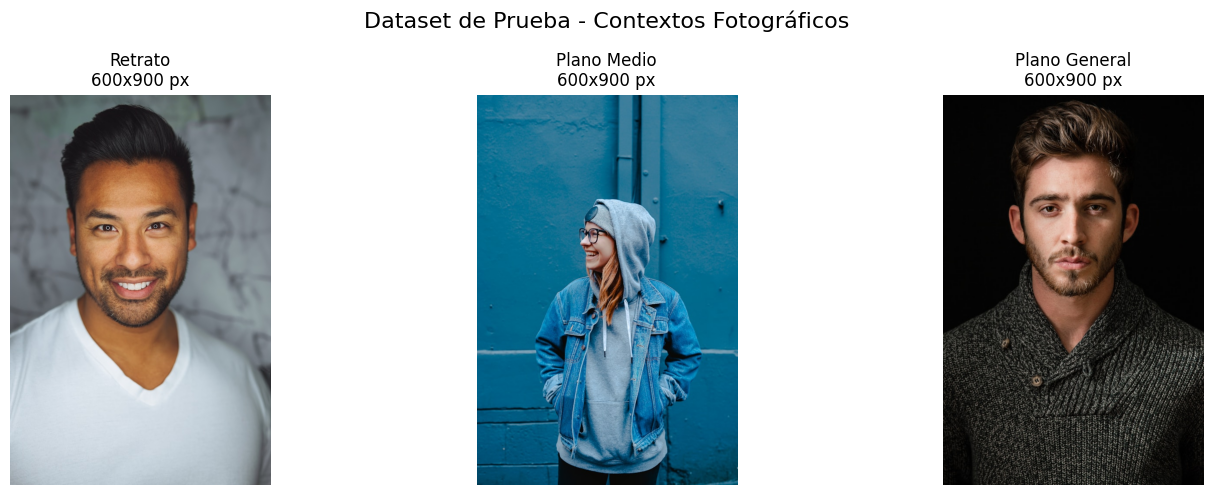

=== CARGA DEL MODELO MASKDINO ===
Modelo cargado en GPU: Tesla T4
MaskDINO-like model listo: facebook/mask2former-swin-base-coco-instance
=== EVALUACIÓN DE MODELO ===
Procesando: retrato
  ✓ Tiempo: 0.160s
  ✓ Personas detectadas: 0
Procesando: plano_medio
  ✓ Tiempo: 0.124s
  ✓ Personas detectadas: 0
Procesando: plano_general
  ✓ Tiempo: 0.139s
  ✓ Personas detectadas: 0
=== REPORTE DE EVALUACIÓN ===
Imágenes procesadas: 3
Exitosos: 3
Fallidos: 0
Tiempo promedio: 0.141s
Total personas detectadas: 0

Resultados por contexto:
  retrato: 0 personas, 0.160s
  plano_medio: 0 personas, 0.124s
  plano_general: 0 personas, 0.139s
Reporte guardado: results/analysis/evaluation_report.json
EVALUACIÓN COMPLETADA
✓ MaskDINO implementado y evaluado correctamente
✓ Listo para agregar modelos adicionales (SAM2, BodyPix, YOLOv8)
✓ Framework preparado para evaluación comparativa


In [34]:
if __name__ == "__main__":
    # Ejecutar framework completo
    success = run_segmentation_evaluation()

    if success:
        print("✓ MaskDINO implementado y evaluado correctamente")
    else:
        print("✗ Error en la evaluación. Revisar logs para detalles.")